# Lab 3: Logistic Regression, Support Vector Machines, and Evaluation


In this lab we'll get some hands on experience with two more classifiers we've seen in class
- Logitic Regression
- Support Vector Machines

We will also explore evaluation metrics that we covered in class and understand how to calculate them.

## Goals for this lab

- Understand the practical implications for changing the parameters used in Logistic Regression and Support Vector Machines
  
- Learn more about the evaluation metrics covered in class and learn how to calculate them (at different thresholds)
  - accuracy
  - precision
  - recall
  - AUC

In [21]:
### import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

import graphviz # If you don't have this, install via pip/conda
from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

# exercise: what additional modules should you import?

# Data
We'll continue to use the same data as in the previous lab.

It is a subset of the data set from https://www.kaggle.com/new-york-state/nys-patient-characteristics-survey-pcs-2015

The data has been downloaded, modified, and is in the github repo for the lab

You should also try this with other data sets you have been provided for the homeworks.

In [2]:
# Change this to wherever you're storing your data
datafile = '../data/nysmedicaldata.csv'
df = pd.read_csv(datafile)

In [3]:
df.head()

,Region Served,Age Group,Sex,Transgender,Sexual Orientation,Hispanic Ethnicity,Race,Living Situation,Household Composition,Preferred Language,...,No Insurance,Unknown Insurance Coverage,Medicaid Insurance,Medicaid Managed Insurance,Medicare Insurance,Private Insurance,Child Health Plus Insurance,Other Insurance,Criminal Justice Status,Three Digit Residence Zip Code
0,HUDSON RIVER REGION,ADULT,MALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,YES,OTHER,OTHER LIVING SITUATION,NOT APPLICABLE,ENGLISH,...,NO,NO,YES,NO,NO,NO,NO,NO,YES,113
1,NEW YORK CITY REGION,ADULT,MALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",WHITE ONLY,INSTITUTIONAL SETTING,NOT APPLICABLE,ENGLISH,...,NO,NO,YES,NO,UNKNOWN,NO,NO,UNKNOWN,YES,113
2,HUDSON RIVER REGION,ADULT,MALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",WHITE ONLY,PRIVATE RESIDENCE,COHABITATES WITH OTHERS,ENGLISH,...,NO,NO,YES,NO,NO,NO,NO,NO,YES,107
3,NEW YORK CITY REGION,ADULT,FEMALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",OTHER,OTHER LIVING SITUATION,NOT APPLICABLE,ASIAN AND PACIFIC ISLAND,...,YES,NO,NO,NOT APPLICABLE,NO,NO,NO,NO,YES,888
4,LONG ISLAND REGION,ADULT,MALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",BLACK ONLY,OTHER LIVING SITUATION,NOT APPLICABLE,ENGLISH,...,NO,NO,YES,UNKNOWN,YES,NO,NO,NO,NO,117


In [4]:
df.dtypes

Region Served                       object
Age Group                           object
Sex                                 object
Transgender                         object
Sexual Orientation                  object
Hispanic Ethnicity                  object
Race                                object
Living Situation                    object
Household Composition               object
Preferred Language                  object
Veteran Status                      object
Employment Status                   object
Number Of Hours Worked Each Week    object
Education Status                    object
Special Education Services          object
Mental Illness                      object
Intellectual Disability             object
Autism Spectrum                     object
Other Developmental Disability      object
Alcohol Related Disorder            object
Drug Substance Disorder             object
Mobility Impairment Disorder        object
Hearing Visual Impairment           object
Hyperlipide

# Some Quick Data Exploration
Before running any sort of model on your dataset, it's always a good idea to do some quick data exploration to get a sense of how your data looks like. Try to answer the following questions with some sort of plot/histogram/etc:

1) What do the distributions of each feature look like?

In [ ]:
# Ex


# Using scikitlearn for classification

sklearn is a very useful python packager for building machiune learning models. To build a model in sklearn, you need to have a matrix (or dataframe) with X and y columns. X is your set of features/predictors. y is a single column that is your label. We'll take the foll;owing steps:

1. Select/create column as label/outcome (y)
2. Select/create columns as features (X)
3. Create Training Set
4. Create Validation Set
5. Build model on Training Set
6. Predict risk scores for the Validation Set
7. Calculate performance metric(s)

## Some useful things to know in sklearn

fit = train an algorithm

predict_proba = predict a "risk" score for all possible classes for a given record (classification only)


## Important- never use .predict
There is also a function called "predict" which first runs predict_probs and then predicts a 1 if the score > 0.5 and 0 otherwise. *Never* use that function since 0.5 is a completely arbitrary threshold to call a prediction 1 vs 0.



## 1. Create label/outcome
One thing we can do with this dataset is to try to use the various feature columns to classify whether a person has High Blood Pressure. Let's create a column that is 1 if a person has High Blood Pressure and 0 otherwise

In [7]:
# code
df["HBP"] = np.where(df["High Blood Pressure"]=="YES",1,0)

### Question: what percentage of people have High Blood Pressure?

In [8]:
# code
df["HBP"].mean()

0.21600738092492217

## 2. create or select existing predictors/features

For now, let's take a handful of existing columns to use.

sklearn needs features to be numeric and not categorical so we'll have to turn our selected features to be binary (also known as dummy variables)

In [9]:
# code
cols_to_transform = [ 'Sex', 'Race', 'Obesity', 'Smokes', 'Alcohol Related Disorder','Drug Substance Disorder',
                    'Criminal Justice Status','Private Insurance']
df = pd.get_dummies( df, dummy_na=True, columns = cols_to_transform )
df.head()

,Region Served,Age Group,Transgender,Sexual Orientation,Hispanic Ethnicity,Living Situation,Household Composition,Preferred Language,Veteran Status,Employment Status,...,Drug Substance Disorder_YES,Drug Substance Disorder_nan,Criminal Justice Status_NO,Criminal Justice Status_UNKNOWN,Criminal Justice Status_YES,Criminal Justice Status_nan,Private Insurance_NO,Private Insurance_UNKNOWN,Private Insurance_YES,Private Insurance_nan
0,HUDSON RIVER REGION,ADULT,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,YES,OTHER LIVING SITUATION,NOT APPLICABLE,ENGLISH,NO,NOT IN LABOR FORCE:UNEMPLOYED AND NOT LOOKING ...,...,1,0,0,0,1,0,1,0,0,0
1,NEW YORK CITY REGION,ADULT,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",INSTITUTIONAL SETTING,NOT APPLICABLE,ENGLISH,NO,NOT IN LABOR FORCE:UNEMPLOYED AND NOT LOOKING ...,...,1,0,0,0,1,0,1,0,0,0
2,HUDSON RIVER REGION,ADULT,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",PRIVATE RESIDENCE,COHABITATES WITH OTHERS,ENGLISH,NO,NOT IN LABOR FORCE:UNEMPLOYED AND NOT LOOKING ...,...,0,0,0,0,1,0,1,0,0,0
3,NEW YORK CITY REGION,ADULT,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",OTHER LIVING SITUATION,NOT APPLICABLE,ASIAN AND PACIFIC ISLAND,NO,NOT IN LABOR FORCE:UNEMPLOYED AND NOT LOOKING ...,...,0,0,0,0,1,0,1,0,0,0
4,LONG ISLAND REGION,ADULT,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",OTHER LIVING SITUATION,NOT APPLICABLE,ENGLISH,NO,NOT IN LABOR FORCE:UNEMPLOYED AND NOT LOOKING ...,...,0,0,1,0,0,0,1,0,0,0


In [10]:
# code
selected_features = ['Sex_FEMALE','Sex_MALE','Sex_UNKNOWN','Race_BLACK ONLY','Race_MULTI-RACIAL','Race_OTHER',
                     'Race_UNKNOWN RACE','Race_WHITE ONLY', 'Obesity_YES', 'Obesity_NO', 'Obesity_nan', 
                     'Smokes_YES', 'Smokes_NO','Alcohol Related Disorder_NO','Alcohol Related Disorder_YES',
                    'Alcohol Related Disorder_UNKNOWN','Criminal Justice Status_YES','Criminal Justice Status_NO',
                    'Criminal Justice Status_UNKNOWN','Private Insurance_NO','Private Insurance_YES','Private Insurance_UNKNOWN']

# Train/Test Splits

Create a train/test set split using sklearn's [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. We'll use these train/test splits for evaluating all our classification models.

In [11]:
# code
x = df[selected_features]
y = df['HBP']
test_size = 0.3 # you can adjust this
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

# Logistic Regression
See the sklearn documentation on Logistic Regression to see its parameters. The one's we'll mostly be interested in are:
- penalty
- C

Remember that when training a model, **you should only use the training data!** The test set is reserved exclusively for evaluating your model. Now let's use the classifier:

In [12]:
# code
lr = LogisticRegression(random_state=0, solver='liblinear')
lr.fit(x_train, y_train)
pred_scores = lr.predict_proba(x_test)

In [13]:
pred_scores

array([[0.76097501, 0.23902499],
       [0.8195065 , 0.1804935 ],
       [0.78648084, 0.21351916],
       ...,
       [0.75978489, 0.24021511],
       [0.7969271 , 0.2030729 ],
       [0.78757567, 0.21242433]])

## Logistic Regression Tasks:

The goal here is to explore different penalty parameters and different C values. You can also try modofyinfg other parameters to see their impact. How does accuracy change, using different thresholds, as you vary penalty and C values? You can write a nested for loop that loops over all the parameters and values and store the results in a data frame (similar to last lab)

Ref: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

You'll notice that LogisticRegression takes a ton of parameters. We'll play around with the "penalty" and "C" parameters.
If we set the penalty parameter to ['l2'](http://mathworld.wolfram.com/L2-Norm.html), sklearn's LogisticRegression model solves the following minimization problem:

$$ \min_{\beta} ||\beta||_2 + C \sum_{i} \log ( -y_i (X_i^T \beta) +1)$$

Similarly, if we set the penalty parameter to ['l1'](http://mathworld.wolfram.com/L2-Norm.html), LogisticRegression will solve the following minimization problem:

$$\min_{\beta} ||\beta||_1 + C \sum_{i} \log ( -y_i (X_i^T \beta) +1)$$

where $$||\beta||_2 = \sqrt { \sum_{i} \beta_i^2 }$$ and $$||\beta||_1 =  \sum_{i} | \beta_i | $$ 

Try running logistic regression with both L1 and L2 penalties and a mix of C values. Something like $10^{-2}, 10^{-1}, 1, 10, 10^2)$ is reasonable.

In [14]:
# code

# we first choose a threshold to determine the pridiction 
print("The true number of HBP is {}/{} from the data, with percentage {:.2f}%\n".format(
    sum(y_test), len(y_test), 100.*sum(y_test)/len(y_test)))
for threshold in [0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7]:
    pred_label = [1 if x[1]>threshold else 0 for x in pred_scores]
    print("(Threshold: {}), the total number of predicted HBP is {}, the accuracy is {:.2f}".format(
        threshold, sum(pred_label), accuracy(pred_label,y_test)))

The true number of HBP is 549/2602 from the data, with percentage 21.10%

(Threshold: 0.1), the total number of predicted HBP is 2545, the accuracy is 0.23
(Threshold: 0.2), the total number of predicted HBP is 1538, the accuracy is 0.49
(Threshold: 0.25), the total number of predicted HBP is 559, the accuracy is 0.71
(Threshold: 0.3), the total number of predicted HBP is 296, the accuracy is 0.76
(Threshold: 0.35), the total number of predicted HBP is 241, the accuracy is 0.77
(Threshold: 0.4), the total number of predicted HBP is 29, the accuracy is 0.79
(Threshold: 0.5), the total number of predicted HBP is 0, the accuracy is 0.79
(Threshold: 0.6), the total number of predicted HBP is 0, the accuracy is 0.79
(Threshold: 0.7), the total number of predicted HBP is 0, the accuracy is 0.79


## Understanding what's going on inside Logistic Regression

To really see the difference between L1 and L2 regularization, we need to take a closer look at the models they produced. Plot a histogram of the weight values of LogisticRegression models for each C value. You can access these weight coefficients via the coef\_ attribute in LogisticRegression. Do you notice anything interesting happening as the C value varies?

In [16]:
# code
threshold = 0.3
penalties = ['l1', 'l2']
c_values = [10**-2, 10**-1, 1 , 10, 10**2]

for norm in tqdm(penalties):
    for reg_strength in c_values:
        lrf = LogisticRegression(random_state=0, solver='liblinear', penalty=norm, C=reg_strength)
        lrf.fit(x_train, y_train)
        
        pred_scores = lrf.predict_proba(x_test)
        pred_label = [1 if x[1] >= threshold else 0 for x in pred_scores]
        acc_score = accuracy(pred_label, y_test)
        
        print('reg: {} | C: {} | total HBP predicted: {} | accuracy is {:.2f}'.format(norm, reg_strength, sum(pred_label), acc_score))

  0%|                                                                      | 0/2 [00:00<?, ?it/s]

reg: l1 | C: 0.01 | total HBP predicted: 461 | accuracy is 0.72
reg: l1 | C: 0.1 | total HBP predicted: 320 | accuracy is 0.76
reg: l1 | C: 1 | total HBP predicted: 297 | accuracy is 0.76
reg: l1 | C: 10 | total HBP predicted: 294 | accuracy is 0.76
reg: l1 | C: 100 | total HBP predicted: 294 | accuracy is 0.76


 50%|███████████████████████████████                               | 1/2 [00:01<00:01,  1.23s/it]

reg: l2 | C: 0.01 | total HBP predicted: 316 | accuracy is 0.76
reg: l2 | C: 0.1 | total HBP predicted: 297 | accuracy is 0.76
reg: l2 | C: 1 | total HBP predicted: 296 | accuracy is 0.76
reg: l2 | C: 10 | total HBP predicted: 294 | accuracy is 0.76
reg: l2 | C: 100 | total HBP predicted: 294 | accuracy is 0.76


100%|██████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.11it/s]


In [19]:
# code
coefs = []

penalties = ['l1', 'l2']
c_values = [10**-2, 10**-1, 1 , 10, 10**2]
threshold = 0.3

for norm in tqdm(penalties):
    coef = []
    for reg_strength in c_values:
        lrf = LogisticRegression(random_state=0, solver='liblinear', penalty=norm, C=reg_strength).fit(x_train, y_train)
        pred_scores = lrf.predict_proba(x_test)
        pred_label = [1 if x[1]>threshold else 0 for x in pred_scores]
        coef.append(lrf.coef_)
        
    coefs.append(coef)

100%|██████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.10it/s]


  0%|                                                                      | 0/2 [00:00<?, ?it/s]

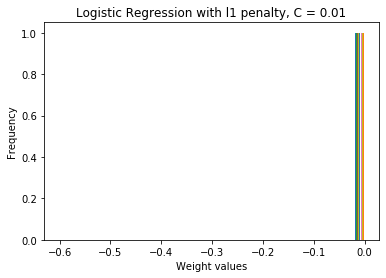

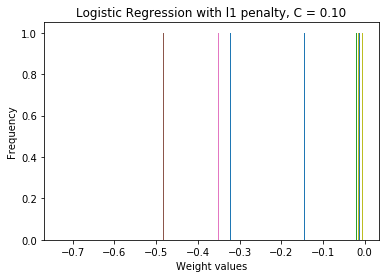

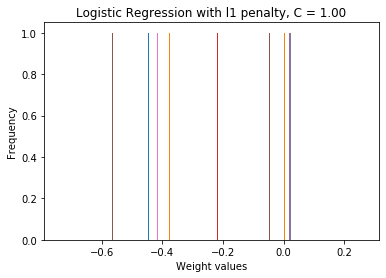

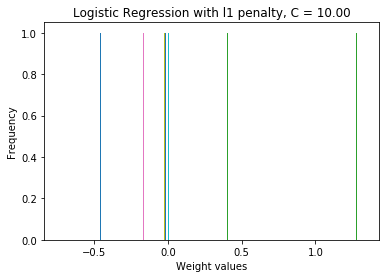

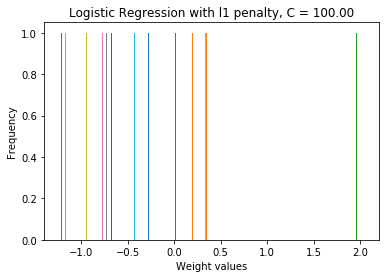

 50%|███████████████████████████████                               | 1/2 [00:11<00:11, 11.20s/it]

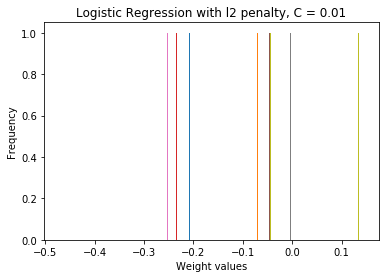

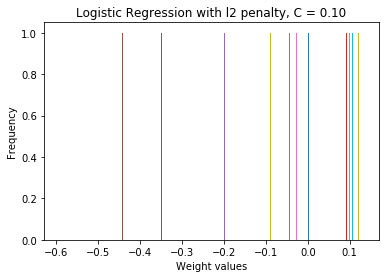

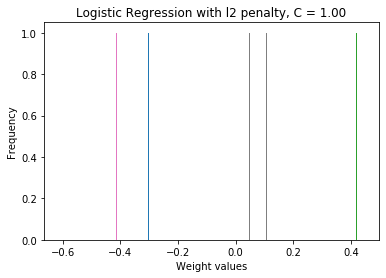

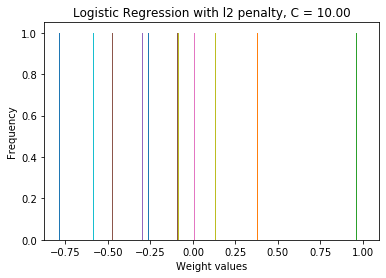

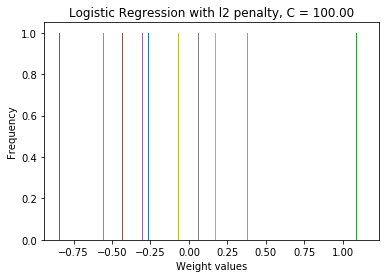

100%|██████████████████████████████████████████████████████████████| 2/2 [00:22<00:00, 11.36s/it]


In [22]:
for p_idx in tqdm(range(len(penalties))):
    for c_idx in range(len(c_values)):
        plt.hist(coefs[p_idx][c_idx], bins = 30)
        plt.title('Logistic Regression with %s penalty, C = %.2f' %(penalties[p_idx], c_values[c_idx]))
        plt.xlabel('Weight values')
        plt.ylabel('Frequency')
        plt.show()

As "C" increases, so does the relative weight of the negative log likelihood of the model. Lower "C" gives a higher relative weight to the L1/L2 penalty.

# Support Vector Machines

Ref: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC
The SVM Classifier also takes quite a few parameters. For now we will use Linear SVMs. The model is called LinearSVC in sklearn.

We will be playing with following parameters:
* C: same as above

SVM tries to find the hyperplane that maximizes the "margin" between the two classes of points. The "C" parameter in [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) has the same role as the "C" parameter in LogisticRegression: it tells you how much to penalize the "size" of the weight vector. Note that SVC only allows for L2 regularization.



### Let's fit an SVM

In [25]:
svm = LinearSVC(random_state=0, tol=1e-5)
svm.fit(x_train, y_train)

# confidence score is the signed distance of the point to the hyperplane
confidence_score = svm.decision_function(x_test)
print(confidence_score[:10])
print("the average of the confidence score is: %.2f" % confidence_score.mean())

[-0.51919769 -0.63441732 -0.56730215 -0.67288028 -0.67575511 -0.66442708
 -0.70986653 -0.69246913 -0.69234445 -0.30610334]
the average of the confidence score is: -0.57


In [24]:
svm.decision_function(x_test)

array([-0.51919769, -0.63441732, -0.56730215, ..., -0.51632287,
       -0.58631286, -0.57017698])

### Now predict scores on the test set and plot the distribution of scores
You might notice that the function you've been using to predict so far does not work. Is another function you need to use? Which one? Why?

In [26]:
print("The true number of HBP is {}/{} from the data, with percentage {:.2f}%\n".format(
    sum(y_test), len(y_test), 100.*sum(y_test)/len(y_test)))

for threshold in tqdm([-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0]):
    pred_label = [1 if x >threshold else 0 for x in confidence_score]
    acc_score = accuracy(pred_label, y_test)
    print("Threshold: {} | total predicted HBP is {} | accuracy is {:.2f}".format(threshold, sum(pred_label), acc_score))

The true number of HBP is 549/2602 from the data, with percentage 21.10%



  0%|                                                                     | 0/11 [00:00<?, ?it/s]

Threshold: -1 | total predicted HBP is 2602 | accuracy is 0.21
Threshold: -0.9 | total predicted HBP is 2597 | accuracy is 0.21
Threshold: -0.8 | total predicted HBP is 2479 | accuracy is 0.25
Threshold: -0.7 | total predicted HBP is 2079 | accuracy is 0.36
Threshold: -0.6 | total predicted HBP is 1596 | accuracy is 0.48
Threshold: -0.5 | total predicted HBP is 596 | accuracy is 0.70
Threshold: -0.4 | total predicted HBP is 362 | accuracy is 0.75
Threshold: -0.3 | total predicted HBP is 203 | accuracy is 0.77
Threshold: -0.2 | total predicted HBP is 22 | accuracy is 0.79


 82%|█████████████████████████████████████████████████▉           | 9/11 [00:00<00:00, 61.61it/s]

Threshold: -0.1 | total predicted HBP is 0 | accuracy is 0.79
Threshold: 0 | total predicted HBP is 0 | accuracy is 0.79


100%|████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 69.08it/s]


### now we can select a threshold and calculate accuracy

choose threshold -0.4 which gives us a number closer to the actual HBP in the population

### Let's now vary values of C and see the results.

In [29]:
threshold = -0.4
c_values = [10**-2, 10**-1, 1 , 10, 10**2]

for c_value in tqdm(c_values):
    svm = LinearSVC(random_state=0, tol=1e-5, C=c_value, max_iter=2000).fit(x_train, y_train)
    confidence_score = svm.decision_function(x_test)
    pred_label = [1 if x > threshold else 0 for x in confidence_score]
    
    acc_score = accuracy(pred_label, y_test)
    print("C: {} | total predicted HBP is {} | accuracy is {:.2f}".format(c_value, sum(pred_label), acc_score))

  0%|                                                                      | 0/5 [00:00<?, ?it/s]

C: 0.01 | total predicted HBP is 367 | accuracy is 0.75
C: 0.1 | total predicted HBP is 362 | accuracy is 0.75
C: 1 | total predicted HBP is 362 | accuracy is 0.75


 60%|█████████████████████████████████████▏                        | 3/5 [00:00<00:00,  8.62it/s]C:\cygwin64\home\darsh\Continuum\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


C: 10 | total predicted HBP is 362 | accuracy is 0.75


 80%|█████████████████████████████████████████████████▌            | 4/5 [00:01<00:00,  1.94it/s]C:\cygwin64\home\darsh\Continuum\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


C: 100 | total predicted HBP is 352 | accuracy is 0.75


100%|██████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.23it/s]


# Evaluation Metrics

We covered several evaluation metrics in class:
    - accuracy
    - precision
    - recall
    - area under curve
    - ROC curves
    
Although sklearn has built-in functions to calculate these metrics,
in this lab we want to give you an understanding of these metrics 
by writing functions to calculate them yourself.

Remember that accuracy, precision, and recall are calculated at a specific threshold for turning scores into 0 and 1.


### Set Threshold


In [ ]:
threshold = -0.4

### We will first create a confusion matrix based on this threshold

In [36]:
svm = LinearSVC(random_state=0, tol=1e-5).fit(x_train, y_train)
confidence_score = svm.decision_function(x_test)
pred_label = [1 if x > threshold else 0 for x in confidence_score]

c = confusion_matrix(y_test, pred_label)
true_negatives, false_positive, false_negatives, true_positives = c.ravel()

# true_positives
# false_positive
# true_negatives
# false_negatives

### Let's now write functions that can calculate each metric

In [37]:
def calculate_confusion_matrix(predicted_scores, true_labels, threshold):
    pred_label = [1 if x > threshold else 0 for x in predicted_scores]
    true_negatives, false_positive, false_negatives, true_positives = confusion_matrix(true_labels, pred_label).ravel()
    return true_negatives, false_positive, false_negatives, true_positives

def calculate_accuracy_at_threshold(predicted_scores, true_labels, threshold):
    tn, fp, fn, tp = calculate_confusion_matrix(predicted_scores, true_labels, threshold)
    return 1.0 * (tp + tn) / (tn + fp + fn + tp)

def calculate_precision_at_threshold(predicted_scores, true_labels, threshold):
    tn, fp, fn, tp = calculate_confusion_matrix(predicted_scores, true_labels, threshold)
    return 1.0 * (tp) / (fp + tp)

def calculate_recall_at_threshold(predicted_scores, true_labels, threshold):
    tn, fp, fn, tp = calculate_confusion_matrix(predicted_scores, true_labels, threshold)
    return 1.0 * (tp) / (fn + tp)

### Now let's calculate all of these for a logistic regression model you built above

In [38]:
threshold = 0.3
lrf = LogisticRegression(random_state=0, solver='liblinear').fit(x_train, y_train)
predicted_scores = lrf.predict_proba(x_test)

print("The accuracy is %.2f" % calculate_accuracy_at_threshold(predicted_scores[:,1], y_test, threshold))
print("The precision is %.2f" % calculate_precision_at_threshold(predicted_scores[:,1], y_test, threshold))
print("The recall is %.2f" % calculate_recall_at_threshold(predicted_scores[:,1], y_test, threshold))

The accuracy is 0.76
The precision is 0.39
The recall is 0.21


### Now let's write a function that generates the precision, recall, k (% of population) graph that we covered in class
<img src="../imgs/prk.png">


In [39]:
def plot_precision_recall_k(predicted_scores, true_labels):
    precision, recall, thresholds = precision_recall_curve(true_labels, predicted_scores)
    plt.plot(recall, precision, marker='.')
    plt.show()

### let's plot it for the same logistic regression model

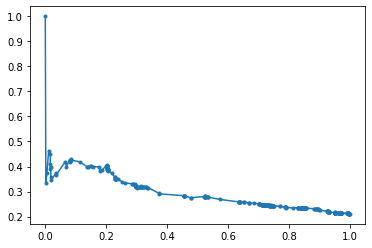

In [40]:
plot_precision_recall_k(predicted_scores[:,1], y_test)

In [46]:
lrf = LogisticRegression(random_state=0, solver='liblinear').fit(x_train, y_train)
predicted_scores = lrf.predict_proba(x_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, predicted_scores)
print(precision, '\n')
print(recall, '\n')
print(thresholds)

[0.21107266 0.21076923 0.21085033 0.21101271 0.21109399 0.21117534
 0.21212121 0.21245136 0.21253406 0.21269965 0.2128655  0.21294852
 0.21311475 0.21344801 0.21397723 0.21406127 0.21414538 0.214342
 0.21323236 0.21291866 0.21334399 0.21311475 0.2132     0.2133707
 0.21345615 0.21362725 0.21371291 0.21379864 0.21397029 0.21391234
 0.21399839 0.21434327 0.21442967 0.21451613 0.21460266 0.21428571
 0.21437222 0.21524118 0.21492295 0.21501014 0.21518473 0.21524664
 0.21533442 0.21542228 0.2155102  0.21487264 0.21496095 0.21504934
 0.21522634 0.21540362 0.21549238 0.21588089 0.21623861 0.21641791
 0.21650767 0.21659751 0.21777967 0.21787234 0.21805792 0.21815083
 0.21781756 0.21791045 0.21800341 0.21935484 0.21944923 0.21963824
 0.21973287 0.22077922 0.22097054 0.22116219 0.22149695 0.22159338
 0.22135076 0.22586521 0.22771363 0.22937063 0.22947761 0.22958469
 0.23109641 0.23142451 0.23153409 0.23164377 0.23135755 0.23180077
 0.23339941 0.23313492 0.23325062 0.23348236 0.23356574 0.2331838

 0.44958533 0.455647   0.45726758]


### Now we build the same graph for an svm model and compare the two. Which one is better?

In [47]:
svm = LinearSVC(random_state=0, tol=1e-5).fit(x_train, y_train)
confidence_score = svm.decision_function(x_test)
# plot_precision_recall_k(predicted_scores[:,1], y_test)
confidence_score

array([-0.51919769, -0.63441732, -0.56730215, ..., -0.51632287,
       -0.58631286, -0.57017698])